In [486]:
import yaml
import os
from functions import print_function
import numpy as np
from keras.datasets import mnist, cifar10
from sklearn.model_selection import train_test_split
import pprint
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Concatenate, AveragePooling2D, Flatten, Dense, BatchNormalization, SpatialDropout2D, GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from copy import deepcopy

class StaticLinear:

    def __init__(self, path):
        self.path = path

        print_function('Retrieving yaml parameters')

        with open(self.path, "r") as stream:
            self.load_yaml = yaml.load(stream, yaml.SafeLoader)

        self.general = self.load_yaml['general']

        self.random_state = np.random.RandomState(self.general['seed_value'])

        self.neat = self.load_yaml['neat']

        self.cnn_layers = self.load_yaml['cnn_layers']

        # convolutional layer parameters
        self.conv_kernel = self.cnn_layers['convolution']['kernel']
        self.conv_filter = self.cnn_layers['convolution']['filter']
        self.conv_padding = self.cnn_layers['convolution']['padding']

        # pooling layer parameters
        self.pool_type = self.cnn_layers['pooling']['type']
        self.pool_size = self.cnn_layers['pooling']['size']
        self.pool_padding = self.cnn_layers['pooling']['padding']

        # dropout layer parameters
        self.dropout_rate_min = np.min(self.cnn_layers['dropout']['rate'])
        self.dropout_rate_max = np.max(self.cnn_layers['dropout']['rate'])


        self.possible_layers = ['convolution','pooling','dropout']


    def load_data(self, X = None, Y = None, use_case_name = None):

        """
        For predefined use cases the data is downloaded and split into training, testing and validation and then saved locally.
        When an X and Y is supplied, the data is sampled, split into training, testing and validation and then saved locally.
        Supply X data and Y data or use the predefined MNIST and CIFAR-10 use cases.
        """

        self.data_params = self.load_yaml['data'] # set the data yaml parameters 

        use_case = self.data_params['use_case'].lower() # get use case value

        if self.data_params['save_data']['set_save_path']: # check if save path is true 
            save_path = self.data_params['save_data']['path'] + '/data/' # set the defined save path

        else:
            save_path = os.getcwd() + '/data/' # else set to current working directory

        # If own data is not supplied and one of the two use cases is not defined then raise error
        if X == None and Y == None and use_case not in ['mnist', 'cifar-10']: 
            raise Exception('No predefined use case provided and no data supplied. Please choose a predefined case or supply data.')

        # If own use case is provided (Gibbon)
        elif X != None and Y != None:

            # Check if own use case name is provided
            if use_case_name != None:
                save_path = save_path + use_case_name + '/'

            # else set to own_use_case
            else:
                save_path = save_path + 'own_use_case' + '/'

            # check if path already exists or if the existing data should be replaced
            if not os.path.exists(save_path) or self.data_params['replace']:

                os.makedirs(save_path, exist_ok=True) # create new directory from save_path value

                # Try load data using provided paths
                try:
                    X = np.load(self.data_params['X_path'])
                    Y = np.load(self.data_params['Y_path'])

                    # if a data sample size is provided then sample own data
                    if self.data_params['data_sample_size'] != None:


                        # g_sample = int(np.floor(self.data_params['test_set_size']/2))
                        # n_sample = self.data_params['test_set_size'] - g_sample

                        # g_i = np.random.randint(0, int(X.shape[0]/2) - 1, g_sample)
                        # n_i = np.random.randint(int(X.shape[0]/2), X.shape[0] - 1, n_sample)

                        # X = np.concatenate([X[g_i], X[n_i]])
                        # Y = np.concatenate([Y[g_i], Y[n_i]])


                        
                        # get sample data that is balance with respect to samples
                        X_sample_train, _, Y_sample_train, _ = train_test_split(X, Y, train_size=self.data_params['data_sample_size']/X.shape[0], random_state=self.general['seed_value'], shuffle = True, stratify = Y)
                        
                        # split into training and testing
                        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X_sample_train, Y_sample_train, test_size=self.data_params['test_set_size'], random_state=self.general['seed_value'], shuffle = True, stratify = Y)
                        
                        # split test set into test and validation
                        self.X_test, self.X_val, self.Y_test, self.Y_val = train_test_split(self.X_test, self.Y_test, test_size=0.5, random_state=self.general['seed_value'], shuffle = True, stratify = Y)

                        # save data to save_path location
                        np.save(save_path + 'X_train.npy', self.X_train)
                        np.save(save_path + 'X_test.npy', self.X_test)
                        np.save(save_path + 'X_val.npy', self.X_val)
                        np.save(save_path + 'Y_train.npy', self.Y_train)
                        np.save(save_path + 'Y_test.npy', self.Y_test)
                        np.save(save_path + 'Y_val.npy', self.Y_val)
                        
                    # else use entire dataset
                    else:
                        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, test_size=self.data_params['test_set_size'], random_state=self.general['seed_value'], shuffle = True, stratify = Y)
                        self.X_test, self.X_val, self.Y_test, self.Y_val = train_test_split(self.X_test, self.Y_test, test_size=0.5, random_state=self.general['seed_value'], shuffle = True, stratify = Y)

                        np.save(save_path + 'X_train.npy', self.X_train)
                        np.save(save_path + 'X_test.npy', self.X_test)
                        np.save(save_path + 'X_val.npy', self.X_val)
                        np.save(save_path + 'Y_train.npy', self.Y_train)
                        np.save(save_path + 'Y_test.npy', self.Y_test)
                        np.save(save_path + 'Y_val.npy', self.Y_val)

                # If it cannot load the data then raise exception
                except:
                    raise Exception(f"Unable to load data from: {self.data_params['X_path'], self.data_params['Y_path']}")

            # Either path exists already and the data should not be replaced then raise exception
            else:
                raise Exception('Could not save provided data.')

        # Raise exception if use case is not defined correctly
        elif use_case not in ['mnist', 'cifar-10']:
            raise Exception('Incorrect data use case provided in yaml. Check spelling or choose one of the available use cases: mnist or cifar-10.')

        # Else a predefined use case has been correctly defined
        else:
            print_function(f"Loading data for use case: {use_case.upper()}")

            
            # When mnist then load mnist data
            if use_case == 'mnist':

                # set save path
                save_path = save_path + 'mnist' + '/'

                # try to load the data
                try:
                    self.X_train = np.load(save_path + 'X_train.npy')
                    self.X_test = np.load(save_path + 'X_test.npy')
                    self.X_val = np.load(save_path + 'X_val.npy')
                    self.Y_train = np.load(save_path + 'Y_train.npy')
                    self.Y_test = np.load(save_path + 'Y_test.npy')
                    self.Y_val = np.load(save_path + 'Y_val.npy')

                # if data cannot be loaded then fetch data
                except:
                    print_function(f"MNIST data not found. Downloading data.")

                    # load mnist data from keras
                    (self.X_train, self.Y_train), (self.X_test, self.Y_test) = mnist.load_data()

                    # sample data based on data sample size
                    if self.data_params['data_sample_size'] != None:

                        self.sample_proportion = self.data_params['data_sample_size']/(self.X_train.shape[0] + self.X_test.shape[0])

                        self.X_train, _, self.Y_train, _ = train_test_split(self.X_train, self.Y_train, train_size=self.sample_proportion, random_state=self.general['seed_value'], shuffle = True, stratify = self.Y_train)
                        self.X_test, _, self.Y_test, _ = train_test_split(self.X_test, self.Y_test, train_size=self.sample_proportion, random_state=self.general['seed_value'], shuffle = True, stratify = self.Y_test)
                    
                    self.X_test, self.X_val, self.Y_test, self.Y_val = train_test_split(self.X_test, self.Y_test, test_size=0.5, random_state=self.general['seed_value'], shuffle = True, stratify = self.Y_test)

                    # if the path does not exist or we want to replace the path then make new directory
                    if not os.path.exists(save_path) or self.data_params['replace']:
                        os.makedirs(save_path, exist_ok=True)

                    # save data
                    np.save(save_path + 'X_train.npy', self.X_train)
                    np.save(save_path + 'X_test.npy', self.X_test)
                    np.save(save_path + 'X_val.npy', self.X_val)
                    np.save(save_path + 'Y_train.npy', self.Y_train)
                    np.save(save_path + 'Y_test.npy', self.Y_test)
                    np.save(save_path + 'Y_val.npy', self.Y_val)

            # When cifar-10 then load cifar-10 data
            elif use_case == 'cifar-10':

                # set save path
                save_path = save_path + 'cifar10' + '/'

                # try to load the data
                try:
                    self.X_train = np.load(save_path + 'X_train.npy')
                    self.X_test = np.load(save_path + 'X_test.npy')
                    self.X_val = np.load(save_path + 'X_val.npy')
                    self.Y_train = np.load(save_path + 'Y_train.npy')
                    self.Y_test = np.load(save_path + 'Y_test.npy')
                    self.Y_val = np.load(save_path + 'Y_val.npy')

                # if data cannot be loaded then fetch data
                except:
                    print_function(f"CIFAR-10 data not found. Downloading data instead.")

                    # load mnist data from keras
                    (self.X_train, self.Y_train), (self.X_test, self.Y_test) = cifar10.load_data()

                    # sample data based on data sample size
                    if self.data_params['data_sample_size'] != None:

                        self.sample_proportion = self.data_params['data_sample_size']/(self.X_train.shape[0] + self.X_test.shape[0])

                        self.X_train, _, self.Y_train, _ = train_test_split(self.X_train, self.Y_train, train_size=self.sample_proportion, random_state=self.general['seed_value'], shuffle = True, stratify = self.Y_train)
                        self.X_test, _, self.Y_test, _ = train_test_split(self.X_test, self.Y_test, train_size=self.sample_proportion, random_state=self.general['seed_value'], shuffle = True, stratify = self.Y_test)
                    
                    self.X_test, self.X_val, self.Y_test, self.Y_val = train_test_split(self.X_test, self.Y_test, test_size=0.5, random_state=self.general['seed_value'], shuffle = True, stratify = self.Y_test)

                    # if the path does not exist or we want to replace the path then make new directory
                    if not os.path.exists(save_path) or self.data_params['replace']:
                        os.makedirs(save_path, exist_ok=True)

                    # save data
                    np.save(save_path + 'X_train.npy', self.X_train)
                    np.save(save_path + 'X_test.npy', self.X_test)
                    np.save(save_path + 'X_val.npy', self.X_val)
                    np.save(save_path + 'Y_train.npy', self.Y_train)
                    np.save(save_path + 'Y_test.npy', self.Y_test)
                    np.save(save_path + 'Y_val.npy', self.Y_val)


    def generate_block_population(self, population_size = None):
        """
        Generate the minimal structure population for the blocks        
        """

        if population_size == None:
            self.population_size = self.neat['block']['population_size']

        else:
            self.population_size = population_size

        population = {}

        for n in range(self.population_size):

            population['individual_' + str(n + 1)] = {
                                                        'nodes':{
                                                            'node_i':{
                                                                'type':'input',
                                                                'attributes':{},
                                                                'n_connections_in':0,
                                                                'connections_in':[],
                                                                'connections_in_enabled':[],
                                                                'nodes_in':[],
                                                                'preceding_nodes':[],
                                                                'n_connections_out':1,
                                                                'connections_out':['connection_1'],
                                                                'connections_out_enabled':[True],
                                                                'nodes_out':['node_o'],
                                                                'following_nodes':['node_o'],
                                                                'connectedness':0
                                                            },
                                                            'node_o':{
                                                                'type':'output',
                                                                'attributes':{},
                                                                'n_connections_in':1,
                                                                'connections_in':['connection_1'],
                                                                'connections_in_enabled':[True],
                                                                'nodes_in':['node_i'],
                                                                'preceding_nodes':['node_i'],
                                                                'n_connections_out':0,
                                                                'connections_out':[],
                                                                'connections_out_enabled':[],
                                                                'nodes_out':[],
                                                                'following_nodes':[],
                                                                'connectedness':1
                                                            }
                                                        },
                                                        'connections':{
                                                            'connection_1':{
                                                                'in':'node_i',
                                                                'out':'node_o',
                                                                'enabled':True,
                                                                'innovation':1
                                                            },
                                                        },
                                                        'scores':{
                                                            'fitness':0,
                                                            'diversity_1':None,
                                                            'diversity_2':None
                                                        },
                                                        'meta_data':{
                                                            'n_nodes':2,
                                                            'n_connections':1,
                                                            'n_enabled':1,
                                                            'n_convolution':0,
                                                            'n_pool':0,
                                                            'n_dropout':0,
                                                            'connection_list':[('node_i', 'node_o', 'connection_1')],
                                                            'connection_list_enabled':[True],
                                                            'node_list':['node_i', 'node_o']
                                                        }
                                                    }
            
        self.population = population
        self.connections = [('node_i', 'node_o', 'connection_1')] # all connections in the population with corresponding input-output nodes 
        self.nodes = ['node_i', 'node_o'] # all nodes in the population

    def get_connections(self, population = None):
        """
        Get all connections in the population
        """

        if population == None:
            population = self.population

        connections = []

        for individual in population:
            for connection in population[individual]['connections']:
                connections.append((population[individual]['connections'][connection]['in'], population[individual]['connections'][connection]['out'], connection))

        return list(set(connections))
    

    def update_connection_list(self, individual_id = None):
        """
        Update the connection list of an individual
        """

        self.population[individual_id]['meta_data']['connection_list'] = [(self.population[individual_id]['connections'][connection]['in'], self.population[individual_id]['connections'][connection]['out'], connection) for connection in self.population[individual_id]['connections']]
    
    
    
    def dfs(self, individual, node, visited = [], following = [], direction = 'forward'): 
        """
        Depth first search algorithm to find all nodes that are connected to a given node
        """

        if direction == 'forward':
            conn_dir = 'connections_out_enabled'
            node_dir = 'nodes_out'

        elif direction == 'backward':
            conn_dir = 'connections_in_enabled'
            node_dir = 'nodes_in'

        else:
            raise ValueError('Direction must be either forward or backward')
        
        if node not in visited:
            
            visited.append(node)
        
            for neighbour in np.array(individual['nodes'][node][node_dir])[individual['nodes'][node][conn_dir]]:
                
                following.append(neighbour)
                
                self.dfs(individual, neighbour, visited, following, direction)

        return list(set(following))

    

    
    
    def add_node(self, probability = None):
        """
        Mutate an individual by adding a node given a certain probability
        """

        # get the mutation index given the probability of mutation for each individual in the population
        mutate_index = np.where(np.random.random(self.population_size) < probability)[0]

        # iterate over the individuals to mutate
        for i in mutate_index:

            # get individual id
            individual_id = 'individual_' + str(i + 1)

            # get random connection to split using the node
            split_connection = np.random.choice(list(self.population[individual_id]['connections'].keys()))

            # get possible layers to define the given node
            layer_type = np.random.choice(self.possible_layers) # Think about adapting p=[0.8, 0.1, 0.1] for conv, pool, dropout

            # define the new node
            if layer_type == 'convolution':
                kernel = np.random.choice(self.conv_kernel) 
                filter = np.random.choice(self.conv_filter)
                node_attr = {'kernel':kernel, 'filter':filter, 'padding':'same'}
                self.population[individual_id]['meta_data']['n_convolution'] += 1
                try:
                    node_id = 'node_c' + str(max([int(item.replace('node_c', '')) for item in self.nodes if 'node_c' in item]) + 1)
                except:
                    node_id = 'node_c1'

            elif layer_type == 'pooling':
                pool_type = np.random.choice(self.pool_type)
                size = np.random.choice(self.pool_size)
                node_attr = {'type':pool_type, 'size':size, 'padding':'same'}
                self.population[individual_id]['meta_data']['n_pool'] += 1
                try:
                    node_id = 'node_p' + pool_type[0] + str(max([int(item.replace('node_p' + pool_type[0], '')) for item in self.nodes if 'node_p' + pool_type[0] in item]) + 1)
                except:
                    node_id = 'node_p' + pool_type[0] + '1'
            else:
                dropout_rate = np.round(np.random.random()*(self.dropout_rate_max - self.dropout_rate_min) + self.dropout_rate_min, 2)
                node_attr = {'rate':dropout_rate}
                self.population[individual_id]['meta_data']['n_dropout'] += 1
                try:
                    node_id = 'node_d' + str(max([int(item.replace('node_d', '')) for item in self.nodes if 'node_d' in item]) + 1)

                except:
                    node_id = 'node_d1'

            
            # the nodes that are connected by the addition of the new node for innovation number tracking
            node_in = self.population[individual_id]['connections'][split_connection]['in']
            node_out = self.population[individual_id]['connections'][split_connection]['out']


            # Check if the nodes are already in the connections list, i.e. new innovation
            # Get the innovation number for the new connections
            if (node_in, node_id) not in [item[0:-1] for item in self.connections]:
                innovation_number_in = len(self.connections) + 1
                self.connections.append((node_in, node_id) + (f'connection_{innovation_number_in}',))

            # If the nodes are already in the connections list, get the innovation number given the position in the list
            else:
                innovation_number_in = [i for i in range(len(self.connections)) if self.connections[i][0:-1] == (node_in, node_id)][0] + 1


            if (node_id, node_out) not in [item[0:-1] for item in self.connections]:
                innovation_number_out = len(self.connections) + 1
                self.connections.append((node_id, node_out) + (f'connection_{innovation_number_out}',))

            else:
                innovation_number_out = [i for i in range(len(self.connections)) if self.connections[i][0:-1] == (node_id, node_out)][0] + 1

            # Define connections based in innovation numbers assigned
            connection_in = f'connection_{innovation_number_in}'
            connection_out = f'connection_{innovation_number_out}'

            for node in [node_id, node_in, node_out]:
                if node not in self.nodes:
                    self.nodes.append(node)

            # Delete the split connection
            del self.population[individual_id]['connections'][split_connection]


            # Update the connection in information
            self.population[individual_id]['connections'][connection_in] = {
                                                                            'in':node_in, 
                                                                            'out':node_id,
                                                                            'enabled':True, 
                                                                            'innovation':innovation_number_in
            }
            
            # Update the connection out information
            self.population[individual_id]['connections'][connection_out] = {
                                                                            'in':node_id, 
                                                                            'out':node_out,
                                                                            'enabled':True, 
                                                                            'innovation':innovation_number_out
            }
            
            # Update the new node information
            self.population[individual_id]['nodes'][node_id] = {
                                                                'type':layer_type,
                                                                'attributes':node_attr,
                                                                'n_connections_in':1,
                                                                'connections_in':[connection_in],
                                                                'connections_in_enabled':[True],
                                                                'nodes_in':[node_in],
                                                                'preceding_nodes':[],
                                                                'n_connections_out':1,
                                                                'connections_out':[connection_out],
                                                                'connections_out_enabled':[True],
                                                                'nodes_out':[node_out],
                                                                'following_nodes':[],
                                                                'connectedness':0
                                                                }

            # Update the input node information
            self.population[individual_id]['nodes'][node_in]['connections_out'] = [conn for conn in self.population[individual_id]['connections'] if self.population[individual_id]['connections'][conn]['in'] == node_in]
            self.population[individual_id]['nodes'][node_in]['connections_out_enabled'] = [self.population[individual_id]['connections'][conn]['enabled'] for conn in self.population[individual_id]['nodes'][node_in]['connections_out']]
            self.population[individual_id]['nodes'][node_in]['nodes_out'] = [self.population[individual_id]['connections'][conn]['out'] for conn in self.population[individual_id]['nodes'][node_in]['connections_out']]

            # Update the output node information
            self.population[individual_id]['nodes'][node_out]['connections_in'] = [conn for conn in self.population[individual_id]['connections'] if self.population[individual_id]['connections'][conn]['out'] == node_out]
            self.population[individual_id]['nodes'][node_out]['connections_in_enabled'] = [self.population[individual_id]['connections'][conn]['enabled'] for conn in self.population[individual_id]['nodes'][node_out]['connections_in']]
            self.population[individual_id]['nodes'][node_out]['nodes_in'] = [self.population[individual_id]['connections'][conn]['in'] for conn in self.population[individual_id]['nodes'][node_out]['connections_in']]

            # The node inherits the preceding connections of the input node. 
            self.population[individual_id]['nodes'][node_id]['preceding_nodes'] = self.population[individual_id]['nodes'][node_in]['preceding_nodes'] + [node_in]
            
            # The node inherits the following connections of the output node. 
            self.population[individual_id]['nodes'][node_id]['following_nodes'] = [node_out] + self.population[individual_id]['nodes'][node_out]['following_nodes']
            
            # Update each preceding node's following nodes such that they now also include the new node and the following nodes of node_out
            # Particularly important for when the chosen connection is previously disabled and now enabled when the new node is added
            for node in self.population[individual_id]['nodes'][node_id]['preceding_nodes']:
                self.population[individual_id]['nodes'][node]['following_nodes'] = list(set([node_id] + self.population[individual_id]['nodes'][node]['following_nodes'] + self.population[individual_id]['nodes'][node_out]['following_nodes']))

            
            # Update each following node's preceding nodes such that they now also include the new node and the preceding nodes of node_in
            for node in self.population[individual_id]['nodes'][node_id]['following_nodes']:
                self.population[individual_id]['nodes'][node]['preceding_nodes'] = list(set(self.population[individual_id]['nodes'][node_in]['preceding_nodes'] + self.population[individual_id]['nodes'][node]['preceding_nodes'] + [node_id]))
            
            # Update the connectedness of the preceding nodes
            for node in self.population[individual_id]['nodes']:
                if len(self.population[individual_id]['nodes'][node]['following_nodes']) > 0 or node == 'node_o':
                    self.population[individual_id]['nodes'][node]['connectedness'] = len(self.population[individual_id]['nodes'][node]['preceding_nodes']) / (len(self.population[individual_id]['nodes'])  - 1)

                else:
                    self.population[individual_id]['nodes'][node]['connectedness'] = 0
                    
            
            # Update meta data
            self.population[individual_id]['meta_data']['n_nodes'] += 1
            self.population[individual_id]['meta_data']['n_connections'] += 1
            self.population[individual_id]['meta_data']['n_enabled'] = sum([1 for item in self.population[individual_id]['connections'] if self.population[individual_id]['connections'][item]['enabled']])
            self.population[individual_id]['meta_data']['connection_list'] = [(self.population[individual_id]['connections'][conn]['in'], self.population[individual_id]['connections'][conn]['out'], conn) for conn in self.population[individual_id]['connections']]
            self.population[individual_id]['meta_data']['connection_list_enabled'] = [self.population[individual_id]['connections'][conn]['enabled'] for conn in self.population[individual_id]['connections']]
            self.population[individual_id]['meta_data']['node_list'] = [node for node in self.population[individual_id]['nodes']]



    def add_connection(self, probability = None):
        """
        Mutate an individual by adding a connection given a certain probability
        """
            
        # mutate a random individual in the population with a given probability
        mutate_index = np.where(np.random.random(self.population_size) < probability)[0]

        for i in mutate_index:

            # determine individual id
            individual_id = 'individual_' + str(i + 1)

            # determine the nodes to connect
            possible_nodes = list(self.population[individual_id]['nodes'].keys())

            # Exclude output node in possible nodes for input to connection
            possible_nodes_in = [x for x in possible_nodes if x != 'node_o']

            # Select a random node in
            node_in = np.random.choice(possible_nodes_in) # maybe look at adding a probablistic bias to this based on relative depth/connectedness

            # Compile node exclusion list and then derive possible nodes that can be used for output connection
            # Exclude list inlcudes: input node (no inputs allowed), node_in (no recursion on itself), nodes_out of node_in (already connected to), preceding nodes of node_in (no recursion on preceding nodes)
            excluded_nodes = ['node_i'] + [node_in] + self.population[individual_id]['nodes'][node_in]['nodes_out'] + self.population[individual_id]['nodes'][node_in]['preceding_nodes']
            possible_nodes_out = [x for x in possible_nodes if x not in excluded_nodes] # Does not allow for recursion

            # If no possible nodes out, continue to next individual
            if len(possible_nodes_out) == 0:
                continue

            # Select a random node out
            else:
                node_out = np.random.choice(possible_nodes_out)

            # Check if the connection already exists in the population and calculate the innovation number accordingly
            if (node_in, node_out) not in [item[0:-1] for item in self.connections]:
                innovation_number = len(self.connections) + 1
                self.connections.append((node_in, node_out) + (f'connection_{innovation_number}',))

            else:
                innovation_number = [i for i in range(len(self.connections)) if self.connections[i][:-1] == (node_in, node_out)][0] + 1

            # Update the individual connection list and enabled connection list
            self.population[individual_id]['meta_data']['connection_list'].append((node_in, node_out)  + (f'connection_{innovation_number}',))
            self.population[individual_id]['meta_data']['connection_list_enabled'].append(True)
                
            # Add the new connection information to the individual
            self.population[individual_id]['connections'][f'connection_{innovation_number}'] = {
                                                                                                'in':node_in, 
                                                                                                'out':node_out,
                                                                                                'enabled':True,
                                                                                                'innovation':innovation_number
            }

            # Update the input node and output node information
            self.population[individual_id]['nodes'][node_in]['n_connections_out'] += 1
            self.population[individual_id]['nodes'][node_in]['connections_out'].append(f'connection_{innovation_number}')
            self.population[individual_id]['nodes'][node_in]['connections_out_enabled'].append(True)
            self.population[individual_id]['nodes'][node_in]['nodes_out'].append(node_out)

            self.population[individual_id]['nodes'][node_out]['n_connections_in'] += 1
            self.population[individual_id]['nodes'][node_out]['connections_in'].append(f'connection_{innovation_number}')
            self.population[individual_id]['nodes'][node_out]['connections_in_enabled'].append(True)
            self.population[individual_id]['nodes'][node_out]['nodes_in'].append(node_in)

            
            # Update the meta data
            self.population[individual_id]['meta_data']['n_connections'] += 1
            self.population[individual_id]['meta_data']['n_enabled'] += 1

    
    def switch_connection(self, probability = None):

        """
        Mutate an individual by switching a connection given a certain probability
        """

        # mutate a random individual in the population with a given probability
        mutate_index = np.where(np.random.random(self.population_size) < probability)[0]

        for i in mutate_index:

            # determine individual id
            individual_id = 'individual_' + str(i + 1)

            # Copy the individual for testing of validity before making changes
            individual = deepcopy(self.population[individual_id])

            # Determine the connections to switch
            possible_connections = list(individual['connections'].keys())

            # Select a random connection to switch
            connection_to_switch = np.random.choice(possible_connections)

            # Get node in and node out
            node_in = individual['connections'][connection_to_switch]['in']
            node_out = individual['connections'][connection_to_switch]['out']

            # Switch the connection
            switched_value = not individual['connections'][connection_to_switch]['enabled']
            individual['connections'][connection_to_switch]['enabled'] = switched_value
            individual['nodes'][node_in]['connections_out_enabled'][individual['nodes'][node_in]['connections_out'].index(connection_to_switch)] = switched_value
            individual['nodes'][node_out]['connections_in_enabled'][individual['nodes'][node_out]['connections_in'].index(connection_to_switch)] = switched_value
            individual['meta_data']['connection_list_enabled'][individual['meta_data']['connection_list'].index((node_in, node_out, connection_to_switch))] = switched_value
            
            # If switch results in True, i.e. the connections goes from enabled to disabled
            if switched_value:

                # The preceding nodes for the out node is updated to include the in node, the in node's preceding nodes and the out node's preceding nodes
                individual['nodes'][node_out]['preceding_nodes'] = list(set(individual['nodes'][node_in]['preceding_nodes'] + [node_in] + individual['nodes'][node_out]['preceding_nodes']))
                
                # Each of the following nodes is then updated to include it's own preceding nodes as well as the out node's preceding nodes
                for node in individual['nodes'][node_out]['following_nodes']:
                    individual['nodes'][node]['preceding_nodes'] = list(set(individual['nodes'][node_out]['preceding_nodes'] + individual['nodes'][node]['preceding_nodes']))
                
                # The following nodes for the in node is updated to include the out node, the out node's following nodes and the in node's following nodes
                individual['nodes'][node_in]['following_nodes'] = list(set(individual['nodes'][node_in]['following_nodes'] +  [node_out] + individual['nodes'][node_out]['following_nodes']))
                
                # Each of the preceding nodes is then updated to include it's own following nodes as well as the in node's following nodes
                for node in self.population[individual_id]['nodes'][node_in]['preceding_nodes']:
                    individual['nodes'][node]['following_nodes'] = list(set(individual['nodes'][node_in]['following_nodes'] + individual['nodes'][node]['following_nodes']))
                
                individual['meta_data']['n_enabled'] += 1

            # If connection goes from enabled to disabled
            else:
                
                # Check if the change has resulted in a discontinuity between input and output
                continuous = 'node_o' in self.dfs(individual, 'node_i', visited = [], following = [], direction = 'forward')

                # If the change has resulted in a discontinuity between input and output, then switch the connection back
                if not continuous:
                    continue

                # If the change has not resulted in a discontinuity, then update the individual
                else:

                    # Update the preceding and following nodes for each node
                    for node in individual['nodes']:

                        individual['nodes'][node]['preceding_nodes'] = self.dfs(individual, node, visited = [], following = [], direction = 'backward')
                        individual['nodes'][node]['following_nodes'] = self.dfs(individual, node, visited = [], following = [], direction = 'forward')

                        # Update the connectedness metric of each node
                        if len(individual['nodes'][node]['following_nodes']) > 0 or node == 'node_o':

                            individual['nodes'][node]['connectedness'] = len(individual['nodes'][node]['preceding_nodes'])/(len(individual['nodes']) - 1)

                        # If there are no following nodes, then the connectedness is 0 (i.e. the node is a dead end)
                        else:
                            individual['nodes'][node]['connectedness'] = 0

                individual['meta_data']['n_enabled'] -= 1


            # Update the population
            self.population[individual_id] = individual


    
    def crossover(self, parent_list, probability = None):
        """
        Crossover between two or more individuals given a certain probability
        """

        # Do not apply crossover if the probability is not met
        if np.random.random() > probability:
            return False
        
        # Define minimal offspring
        else:
            offspring = {
                        'nodes':{
                            'node_i':{
                                'type':'input',
                                'attributes':{}
                            },
                            'node_o':{
                                'type':'output',
                                'attributes':{}
                            }
                        },
                        'connections':{
                        },
                        'scores':{
                            'fitness':0,
                            'diversity_1':None,
                            'diversity_2':None
                        },
                        'meta_data':{
                        }
                    }

            # Get all innovations/connections and all unique innovations/connections given the parent list
            all_innovations = []

            for parent in parent_list:

                for connection in list(self.population[parent]['connections'].keys()):

                    all_innovations.append(connection)
            
            all_innovations_set = list(set(all_innovations))
            
            # Loop through all unique innovations
            for innovation in all_innovations_set:

                # Count the number of times the innovation appears in all innovations
                n_occurances = len([item for item in all_innovations if item == innovation])
                
                # Check the number of appearances match the number of parents
                if n_occurances == len(parent_list):

                    # Randomly select a parent to inherit the connection
                    gene_parent = np.random.choice(parent_list)

                # If the innovation does not appear in all parents, select the parent with the highest fitness
                else:
                    gene_parent = parent_list[np.argmax([self.population[parent]['scores']['fitness'] for parent in parent_list])]

                # Inherit the connection from the selected parent
                # If there is no connection to inherit (no corresponding innovation), then skip to the next innovation, i.e. inherit nothing
                try:
                    
                    inherit_connection = self.population[gene_parent]['connections'][innovation]
                    offspring['connections'][innovation] = inherit_connection

                    # Get node in and out of connection
                    node_in = inherit_connection['in']
                    node_out = inherit_connection['out']

                    # Get the node information
                    offspring['nodes'][node_in] = self.population[gene_parent]['nodes'][node_in]
                    offspring['nodes'][node_out] = self.population[gene_parent]['nodes'][node_out]

                    # Update the connection list
                    offspring['meta_data']['connection_list'].append((node_in, node_out, innovation))
                    
                except:
                    continue

            # Update the node information
            for node in offspring['nodes']:

                # For the input node
                if node == 'node_i':

                    # No inputs
                    offspring['nodes'][node]['connections_in'] = []
                    offspring['nodes'][node]['nodes_in'] = []
                    offspring['nodes'][node]['connections_in_enabled'] = []
                    offspring['nodes'][node]['n_connections_in'] = 0
                    offspring['nodes'][node]['preceding_nodes'] = []

                    # Update output information
                    offspring['nodes'][node]['connections_out'] = [conn for conn in offspring['connections'] if node == offspring['connections'][conn]['in']]
                    offspring['nodes'][node]['nodes_out'] = [offspring['connections'][conn]['out'] for conn in offspring['nodes'][node]['connections_out']]
                    offspring['nodes'][node]['connections_out_enabled'] = [offspring['connections'][conn]['enabled'] for conn in offspring['nodes'][node]['connections_out']]
                    offspring['nodes'][node]['n_connections_out'] = len(offspring['nodes'][node]['connections_out'])
                    offspring['nodes'][node]['following_nodes'] = self.dfs(offspring, node, visited = [], following = [], direction = 'forward')

                    # Connectedness is zero since there are no preceding nodes
                    offspring['nodes'][node]['connectedness'] = 0

                # For the output node
                elif node == 'node_o':

                    # Update input information
                    offspring['nodes'][node]['connections_in'] = [conn for conn in offspring['connections'] if node == offspring['connections'][conn]['out']]
                    offspring['nodes'][node]['nodes_in'] = [offspring['connections'][conn]['in'] for conn in offspring['nodes'][node]['connections_in']]
                    offspring['nodes'][node]['connections_in_enabled'] = [offspring['connections'][conn]['enabled'] for conn in offspring['nodes'][node]['connections_in']]
                    offspring['nodes'][node]['n_connections_in'] = len(offspring['nodes'][node]['connections_in'])
                    offspring['nodes'][node]['preceding_nodes'] = self.dfs(offspring, node, visited = [], following = [], direction = 'backward')

                    # No outputs
                    offspring['nodes'][node]['connections_out'] = []
                    offspring['nodes'][node]['nodes_out'] = []
                    offspring['nodes'][node]['connections_out_enabled'] = []
                    offspring['nodes'][node]['n_connections_out'] = 0
                    offspring['nodes'][node]['following_nodes'] = []

                    # Connectedness is one since all are preceding nodes
                    offspring['nodes'][node]['connectedness'] = 1

                # For all internal nodes
                else:

                    # Update input information
                    offspring['nodes'][node]['connections_in'] = [conn for conn in offspring['connections'] if offspring['connections'][conn]['out'] == node]
                    offspring['nodes'][node]['nodes_in'] = [offspring['connections'][conn]['in'] for conn in offspring['nodes'][node]['connections_in']]
                    offspring['nodes'][node]['connections_in_enabled'] = [offspring['connections'][conn]['enabled'] for conn in offspring['nodes'][node]['connections_in']]
                    offspring['nodes'][node]['n_connections_in'] = sum([offspring['connections'][conn]['enabled'] for conn in offspring['nodes'][node]['connections_in']])
                    offspring['nodes'][node]['preceding_nodes'] = self.dfs(offspring, node, visited = [], following = [], direction = 'backward')

                    # Update output information
                    offspring['nodes'][node]['connections_out'] = [conn for conn in offspring['connections'] if offspring['connections'][conn]['in'] == node]
                    offspring['nodes'][node]['nodes_out'] = [offspring['connections'][conn]['out'] for conn in offspring['nodes'][node]['connections_out']]
                    offspring['nodes'][node]['connections_out_enabled'] = [offspring['connections'][conn]['enabled'] for conn in offspring['nodes'][node]['connections_out']]
                    offspring['nodes'][node]['n_connections_out'] = sum([offspring['connections'][conn]['enabled'] for conn in offspring['nodes'][node]['connections_out']])
                    offspring['nodes'][node]['following_nodes'] = self.dfs(offspring, node, visited = [], following = [], direction = 'forward')

                    # Calculate the connectedness based on the preceding nodes and the total nodes
                    if len(offspring['nodes'][node]['following_nodes']) > 0:
                        offspring['nodes'][node]['connectedness'] = len(offspring['nodes'][node]['preceding_nodes']) / (len(offspring['nodes']) - 1)

                    # If there are no following nodes, then the connectedness is zero (i.e. dead node)
                    else:
                        offspring['nodes'][node]['connectedness'] = 0

            # Update the meta data
            offspring['meta_data']['n_nodes'] = len(offspring['nodes'])
            offspring['meta_data']['n_connections'] = len(offspring['connections'])
            offspring['meta_data']['n_enabled'] = sum([offspring['connections'][conn]['enabled'] for conn in offspring['connections']])
            offspring['meta_data']['n_convolution'] = len([node for node in offspring['nodes'] if offspring['nodes'][node]['type'] == 'convolution'])
            offspring['meta_data']['n_pool'] = len([node for node in offspring['nodes'] if offspring['nodes'][node]['type'] == 'pooling'])
            offspring['meta_data']['n_dropout'] = len([node for node in offspring['nodes'] if offspring['nodes'][node]['type'] == 'dropout'])
            offspring['meta_data']['connection_list'] = [(offspring['connections'][conn]['in'], offspring['connections'][conn]['out'], conn) for conn in offspring['connections']]
            offspring['meta_data']['connection_list_enabled'] = [offspring['connections'][conn]['enabled'] for conn in offspring['connections']]
            offspring['meta_data']['node_list'] = list(offspring['nodes'].keys())
            
            return offspring
    

    
    def node_layers(self, individual, inputs = None):
        """
        Define the layers for each node in the individual.
        Ignore the layer if it is already defined.
        """

        # Loop through all nodes
        for node in individual['nodes']:

            # If the layer already exists, then skip the node
            try:
                individual['nodes'][node]['layer']

            except:

                # If the node is the input node, then set the layer equal to the inputs
                if node == 'node_i':
                    individual['nodes'][node]['attributes']['layer_object'] = inputs
                    individual['nodes'][node]['layer'] = inputs
                    individual['nodes'][node]['concat_list'] = []
                    individual['nodes'][node]['concat_list_names'] = []

                # If the node is the output node, then set the layer equal to None since it is defined by previous incoming layer(s)
                elif node == 'node_o':
                    individual['nodes'][node]['layer'] = None
                    individual['nodes'][node]['concat_list'] = []
                    individual['nodes'][node]['concat_list_names'] = []

                # If the node is anything other than the input node or the output node
                else:

                    # If the node is a convolution node
                    if individual['nodes'][node]['type'] == 'convolution':

                        # Get the attributes of the convolution node
                        filters = individual['nodes'][node]['attributes']['filter']
                        kernel = (individual['nodes'][node]['attributes']['kernel'], individual['nodes'][node]['attributes']['kernel'])
                        padding = individual['nodes'][node]['attributes']['padding']

                        # Set the layer to a convolution layer
                        individual['nodes'][node]['attributes']['layer_object'] = Conv2D(filters = filters, kernel_size = kernel, padding = padding, name = node) 

                        # Functional layer is empty
                        individual['nodes'][node]['layer'] = None
                        individual['nodes'][node]['concat_list'] = []
                        individual['nodes'][node]['concat_list_names'] = []

                    # If the node is a pooling node
                    elif individual['nodes'][node]['type'] == 'pooling':

                        # Get the attributes of the pooling node
                        pool_size = (individual['nodes'][node]['attributes']['size'], individual['nodes'][node]['attributes']['size'])
                        pool_type = individual['nodes'][node]['attributes']['type']
                        padding = individual['nodes'][node]['attributes']['padding']

                        # Set the layer to a pooling layer
                        if pool_type == 'max':
                            individual['nodes'][node]['attributes']['layer_object'] = MaxPooling2D(pool_size = pool_size, strides=(1, 1), padding = padding, name = node)

                        elif pool_type == 'average':
                            individual['nodes'][node]['attributes']['layer_object'] = AveragePooling2D(pool_size = pool_size, strides=(1, 1), padding = padding, name = node)

                        else:
                            raise Exception('Invalid pooling type')
                        
                        # Functional layer is empty
                        individual['nodes'][node]['layer'] = None
                        individual['nodes'][node]['concat_list'] = []
                        individual['nodes'][node]['concat_list_names'] = []

                    # If the node is a dropout node
                    elif individual['nodes'][node]['type'] == 'dropout':

                        # Get the attributes of the dropout node
                        rate = individual['nodes'][node]['attributes']['rate']

                        # Set the layer to a dropout layer
                        individual['nodes'][node]['attributes']['layer_object'] = SpatialDropout2D(rate = rate, name = node)

                        # Functional layer is empty
                        individual['nodes'][node]['layer'] = None
                        individual['nodes'][node]['concat_list'] = []
                        individual['nodes'][node]['concat_list_names'] = []

                    else:
                        raise Exception('Invalid node type')
                
        return individual
    
    
    
    # Single inputs are being added to the concat list. Need to figure out what is happening there.
    
    def build_block(self, individual, node = 'node_i', visited = []):
        """
        Limited depth first search algorithm to define layers for each node in the individual given the preceding nodes as input.
        Nodes with single inputs are immediately defined by the previous node's layer as input.
        Nodes with multiple inputs are defined by the concatenation of the previous nodes' layers as input. 
        """
        
        # If the node has not been visited
        if node not in visited:

            # Check if the layer object is defined
            try:
                # Ouput layer is defined by the nodes coming into it, so it is ignored
                if node != 'node_o':
                    individual['nodes'][node]['attributes']['layer_object']
                else:
                    pass
                
            # Raise exception if the layer object has not been defined
            except:
                raise Exception(f'The layer for {node} is not defined. Try running node_layers(individual, inputs) first.')
            
            # Add the node to the visited list
            visited.append(node)

            print('Node: ', node)

            # Get valid neighbours, i.e. those that form a connection to both input and output nodes
            valid_neighbours = []
            all_neighbours = individual['nodes'][node]['nodes_out']
            for i in range(len(all_neighbours)):
                if individual['nodes'][node]['connections_out_enabled'][i] and 'node_i' in individual['nodes'][all_neighbours[i]]['preceding_nodes']:
                    if all_neighbours[i] == 'node_o':
                        valid_neighbours.append(all_neighbours[i])

                    elif 'node_o' in individual['nodes'][all_neighbours[i]]['following_nodes']:
                        valid_neighbours.append(all_neighbours[i])

        
            # Iterate through the nodes that the current node is connected to via enabled connections
            # np.array(individual['nodes'][node]['nodes_out'])[individual['nodes'][node]['connections_out_enabled']]
            for neighbour in valid_neighbours:

                print('_____Neighbour: ', neighbour)

                n_valid_connections_in = sum([1 for n in valid_neighbours if n in individual['nodes'][neighbour]['nodes_in']])
                
                # If the neighbouring node has only one incoming connection
                # sum(individual['nodes'][neighbour]['connections_in_enabled'])
                if n_valid_connections_in == 1:

                    # If the neighbouring node is the output node
                    if neighbour == 'node_o':

                        # Set the output node to the preceding node's layer
                        individual['nodes'][neighbour]['layer'] = individual['nodes'][node]['layer']
                        individual['nodes'][neighbour]['attributes']['layer_object'] = individual['nodes'][node]['attributes']['layer_object']

                    # If the neighbouring node is not the output node
                    else:

                        # Define the neighbouring node's layer with the preceding node's layer as input
                        individual['nodes'][neighbour]['layer'] = individual['nodes'][neighbour]['attributes']['layer_object'](individual['nodes'][node]['layer'])
                        
                        # Recursively call the function to define the layers for the neighbouring node, i.e. depth first search while the neighbouring node has only one incoming connection
                        self.build_block(individual, neighbour, visited)
                
                # If the neighbouring node has more than one incoming connection
                else:
                    
                    # Add the preceding node's layer to the neighbouring node's list of layers to concatenate
                    individual['nodes'][neighbour]['concat_list'].append(individual['nodes'][node]['layer'])
                    individual['nodes'][neighbour]['concat_list_names'].append(node)

                    # If all the layers for the input nodes to the neighbouring node have been defined and added to the list of layers to concatenate
                    if sum(individual['nodes'][neighbour]['connections_in_enabled']) == len(individual['nodes'][neighbour]['concat_list']):

                        # If the neighbouring node is the output node define it as a concatenation layer
                        if neighbour == 'node_o':
                            individual['nodes'][neighbour]['attributes']['layer_object'] = Concatenate(name = 'node_o')
                            individual['nodes'][neighbour]['layer'] = individual['nodes'][neighbour]['attributes']['layer_object']

                        # Concatenate the layers in the list of layers to concatenate and give it as input to define the neighbouring node's layer
                        else:
                            individual['nodes'][neighbour]['layer'] = individual['nodes'][neighbour]['attributes']['layer_object'](Concatenate(name = '_'.join(individual['nodes'][neighbour]['concat_list_names']))(individual['nodes'][neighbour]['concat_list']))
                        
                        # Recursively call the function to define the layers for the next neighbouring node.
                        self.build_block(individual, neighbour, visited)
                
        # Return the updated individual
        return individual

In [487]:
# inputs = block_individual_1['nodes']['node_i']['layer']
# outputs = block_individual_1['nodes']['node_o']['layer']

# # Create the model
# model = keras.Model(inputs=inputs, outputs=outputs, name="block_cnn")

# # Print the summary of the model
# model.summary()

# flatten = layers.Flatten()(layer_out)
# outputs = layers.Dense(10, activation="softmax")(flatten)

# # Create the model
# model = keras.Model(inputs=inputs, outputs=outputs, name="recursive_cnn")

# # Print the summary of the model
# model.summary()

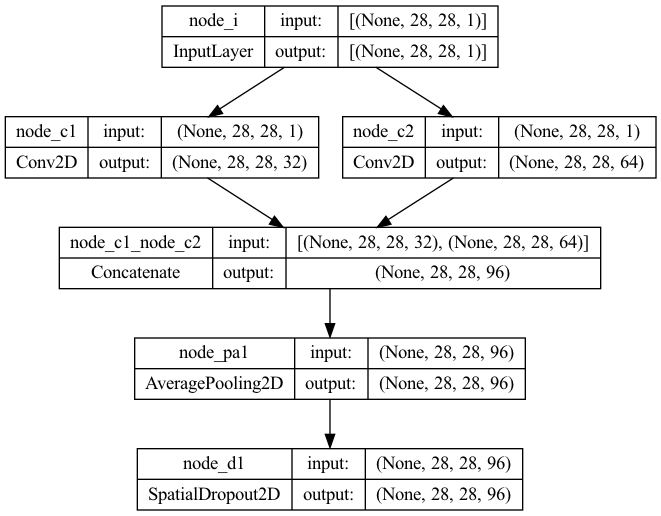

In [488]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [489]:
data = StaticLinear('parameters.yaml')
data.generate_block_population()
pprint.pprint(data.population)

Retrieving yaml parameters...
__________________________________________________
{'individual_1': {'connections': {'connection_1': {'enabled': True,
                                                   'in': 'node_i',
                                                   'innovation': 1,
                                                   'out': 'node_o'}},
                  'meta_data': {'connection_list': [('node_i',
                                                     'node_o',
                                                     'connection_1')],
                                'connection_list_enabled': [True],
                                'n_connections': 1,
                                'n_convolution': 0,
                                'n_dropout': 0,
                                'n_enabled': 1,
                                'n_nodes': 2,
                                'n_pool': 0,
                                'node_list': ['node_i', 'node_o']},
                  'node

In [490]:
data.load_data()

Loading data for use case: MNIST...
__________________________________________________


In [491]:
for i in range(2):
    data.add_node(1)
    for ind in data.population:
        if len(data.population[ind]['nodes']['node_o']['connections_out']) > 0 or len(data.population[ind]['nodes']['node_i']['connections_in']) > 0:
            print('Ind: ', ind)
            print('After adding node')
            break

    data.add_connection(1)
    for ind in data.population:
        if len(data.population[ind]['nodes']['node_o']['connections_out']) > 0 or len(data.population[ind]['nodes']['node_i']['connections_in']) > 0:
            print('Ind: ', ind)
            print('After adding connection')
            break
    else:
        continue
    break

In [492]:
for i in range(2):
    data.switch_connection(1)
    for ind in data.population:
        if len(data.population[ind]['nodes']['node_o']['connections_out']) > 0 or len(data.population[ind]['nodes']['node_i']['connections_in']) > 0:
            print('Ind: ', ind)
            print('After switching connection')
            break
    else:
        continue
    break

In [493]:
parent_list = ['individual_1', 'individual_2']
offspring = data.crossover(parent_list, 1)
pprint.pprint(offspring)

{'connections': {'connection_1': {'enabled': True,
                                  'in': 'node_i',
                                  'innovation': 1,
                                  'out': 'node_o'},
                 'connection_2': {'enabled': True,
                                  'in': 'node_i',
                                  'innovation': 2,
                                  'out': 'node_d1'},
                 'connection_22': {'enabled': True,
                                   'in': 'node_d1',
                                   'innovation': 22,
                                   'out': 'node_c5'},
                 'connection_23': {'enabled': True,
                                   'in': 'node_c5',
                                   'innovation': 23,
                                   'out': 'node_o'}},
 'meta_data': {'connection_list': [('node_i', 'node_o', 'connection_1'),
                                   ('node_d1', 'node_c5', 'connection_22'),
                    

In [494]:
for individual in data.population:
    data.node_layers(data.population[individual], inputs = Input(shape = (28, 28, 1), name = 'node_i'))

In [495]:
pprint.pprint(data.population)

{'individual_1': {'connections': {'connection_1': {'enabled': True,
                                                   'in': 'node_i',
                                                   'innovation': 1,
                                                   'out': 'node_o'},
                                  'connection_2': {'enabled': True,
                                                   'in': 'node_i',
                                                   'innovation': 2,
                                                   'out': 'node_d1'},
                                  'connection_22': {'enabled': True,
                                                    'in': 'node_d1',
                                                    'innovation': 22,
                                                    'out': 'node_c5'},
                                  'connection_23': {'enabled': True,
                                                    'in': 'node_c5',
                                      

In [496]:
for individual in data.population:
    data.build_block(data.population[individual], node = 'node_i', visited = [])

pprint.pprint(data.population)

Node:  node_i
_____Neighbour:  node_o
_____Neighbour:  node_d1
Node:  node_d1
_____Neighbour:  node_c5
Node:  node_c5
_____Neighbour:  node_o
Node:  node_o
Node:  node_i
_____Neighbour:  node_c1
Node:  node_c1
_____Neighbour:  node_o
Node:  node_i
_____Neighbour:  node_c2
Node:  node_c2
_____Neighbour:  node_pm3
Node:  node_pm3
_____Neighbour:  node_o
Node:  node_o
Node:  node_i
_____Neighbour:  node_o
_____Neighbour:  node_d5
Node:  node_d5
_____Neighbour:  node_d2
_____Neighbour:  node_d2
Node:  node_d2
_____Neighbour:  node_o
Node:  node_i
_____Neighbour:  node_c3
Node:  node_c3
_____Neighbour:  node_o
Node:  node_i
_____Neighbour:  node_d6
Node:  node_d6
_____Neighbour:  node_o
Node:  node_o
Node:  node_i
_____Neighbour:  node_d3
Node:  node_d3
_____Neighbour:  node_c6
Node:  node_c6
_____Neighbour:  node_o
Node:  node_o
Node:  node_i
_____Neighbour:  node_o
Node:  node_i
_____Neighbour:  node_c4
Node:  node_c4
_____Neighbour:  node_o
_____Neighbour:  node_pa3
Node:  node_pa3
_____

In [35]:
def parse_block(individual_id, node = 'node_i', target_node = 'node_o'):

    input_layer = data.population[individual_id]['nodes'][node]['layer']

    for node_out in [data.population[individual_id]['connections'][conn]['out'] for conn in data.population[individual_id]['connections'] if data.population[individual_id]['connections'][conn]['in'] == node and data.population[individual_id]['connections'][conn]['enabled']]:
        next_layer = data.population[individual_id]['nodes'][node_out]['layer']

        data.population[individual_id]['nodes'][node_out]['layer'] = next_layer(input_layer)

In [36]:
parse_block('individual_1')

node_pm8
node_c15
node_pa4
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node_c30
node_c20
node_o
node_c10
node_pa1
node_pa15
node_pm10
node_c7
node

RecursionError: maximum recursion depth exceeded while calling a Python object

In [34]:
data.build_block(individual='individual_1')

[[<keras.layers.convolutional.conv2d.Conv2D object at 0x289bb4a00>, <keras.layers.pooling.average_pooling2d.AveragePooling2D object at 0x2896c1e20>, <KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'input_1')>], [<keras.layers.convolutional.conv2d.Conv2D object at 0x289bb4d30>], [<keras.layers.convolutional.conv2d.Conv2D object at 0x289bb46d0>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x289bba730>], [<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x289bba730>], [<keras.layers.pooling.average_pooling2d.AveragePooling2D object at 0x2896c1d30>, <keras.layers.convolutional.conv2d.Conv2D object at 0x2898b7bb0>], [<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x2896c1b20>, <keras.layers.pooling.average_pooling2d.AveragePooling2D object at 0x2896c1e20>], [<keras.layers.convolutional.conv2d.Conv2D object at 0x2898b7bb0>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x289bba730>], [<KerasTensor: shape=(None, 28, 28, 1

TypeError: object of type 'NoneType' has no len()

In [25]:
individual_1 = {'a':{1:2, 3:4}, 'b':{5:6, 7:8}}
print(id(individual_1))
print(individual_1)
individual_2 = individual_1.copy()
print(id(individual_2))
print(individual_2)
individual_2['a'][1] = 10
individual_1['b'][1] = 10
print(id(individual_1))
print(individual_1)
print()
print(id(individual_2))
print(individual_2)

10987432960
{'a': {1: 2, 3: 4}, 'b': {5: 6, 7: 8}}
10987351744
{'a': {1: 2, 3: 4}, 'b': {5: 6, 7: 8}}
10987432960
{'a': {1: 10, 3: 4}, 'b': {5: 6, 7: 8, 1: 10}}

10987351744
{'a': {1: 10, 3: 4}, 'b': {5: 6, 7: 8, 1: 10}}


In [646]:
def build_block(individual, inputs = None):
        
    if inputs is None:

        try:
            input_shape = data.X_train.shape[1:] + (1,)

        except:
            raise Exception('Run the load_data() method before building the block')
        
        inputs = Input(shape=input_shape)

    else:
        raise Exception('Provide valid input')

    nodes = data.population[individual]['nodes']
    connections = data.population[individual]['connections']


    for node in nodes:
        if node == 'node_i':
            nodes[node]['layer'] = inputs

            # Enable all connections from the input node if the input is not a keras standard input layer, i.e. can be concatenated
            if 'input' not in inputs.name:
                for connection in connections:
                    if not connections[connection]['enabled']:
                        connections[connection]['enabled'] = True


        elif node != 'node_i' and node != 'node_o':
            if nodes[node]['type'] == 'convolution':
                filters = nodes[node]['attributes']['filter']
                kernel = (nodes[node]['attributes']['kernel'], nodes[node]['attributes']['kernel'])
                padding = nodes[node]['attributes']['padding']
                nodes[node]['layer'] = Conv2D(filters = filters, kernel_size = kernel, padding = padding) 

            elif nodes[node]['type'] == 'pooling':
                pool_size = (nodes[node]['attributes']['size'], nodes[node]['attributes']['size'])
                pool_type = nodes[node]['attributes']['type']
                padding = nodes[node]['attributes']['padding']
                if pool_type == 'max':
                    nodes[node]['layer'] = MaxPooling2D(pool_size = pool_size, padding = padding)

                elif pool_type == 'average':
                    nodes[node]['layer'] = AveragePooling2D(pool_size = pool_size, padding = padding)

                else:
                    raise Exception('Invalid pooling type')

            elif nodes[node]['type'] == 'dropout':
                rate = nodes[node]['attributes']['rate']
                nodes[node]['layer'] = Dropout(rate = rate)

            else:
                raise Exception('Invalid node type')
            

    nodes_in = ['node_i']
    output_layers_concat = []

    while 'node_o' not in nodes_in:

        nodes_out = []

        for node in nodes_in:
            print(50*'-')
            print('Node ', node, ' from input nodes ', nodes_in)

            for connection in connections:

                print('Connection ', connection, ' from node ', connections[connection]['in'], ' to node ', connections[connection]['out'], ' enabled ', connections[connection]['enabled'])

                if connections[connection]['in'] == node and connections[connection]['out'] != 'node_o' and connections[connection]['enabled']:

                    print(f"Node {connections[connection]['in']} == {node} and {connections[connection]['out']} != 'node_o' and enabled = {connections[connection]['enabled']}")
                    
                    node_out = connections[connection]['out']
                    nodes_out.append(node_out)

                    # print('Node out ', node_out, ' n connections in ', nodes[node_out]['n_connections_in'])

                    if nodes[node_out]['n_connections_in'] == 1:

                        print(f"Node {node_out} has only one connection in")
                        print(f"Node {node_out} has {nodes[node_out]['n_connections_in']} connections in")
                        nodes[node_out]['layer'] = nodes[node_out]['layer'](nodes[node]['layer'])

                    else:

                        print(f"Node {node_out} has more than one connection in")
                        print(f"Node {node_out} has {nodes[node_out]['n_connections_in']} connections in")
                        nodes_in_concat = [connections[conn]['in'] for conn in connections if connections[conn]['out'] == node_out and connections[conn]['enabled']]
                        layers_in_concat = [nodes[node_concat]['layer'] for node_concat in nodes_in_concat]
                        print('Layers to concat: ', layers_in_concat)
                        # print(layers_in_concat)
                        nodes[node_out]['layer'] = nodes[node_out]['layer'](Concatenate()(layers_in_concat))

                elif connections[connection]['out'] == 'node_o' and connections[connection]['enabled']:

                    # print('Connection ', connection, ' from node ', connections[connection]['in'], ' to node ', connections[connection]['out'], ' enabled ', connections[connection]['enabled'])

                    output_layers_concat.append(nodes[connections[connection]['in']]['layer'])

                    # print('Output layers concat ', output_layers_concat, ' output cnt ', len(output_layers_concat), ' n connections in ', nodes['node_o']['n_connections_in'])

                    if len(output_layers_concat) == nodes['node_o']['n_connections_in']:
                        nodes['node_o']['layer'] = Concatenate()(output_layers_concat)
                        nodes_out = ['node_o']

        nodes_in = nodes_out
                
            
        nodes_in = ['node_o']

    return nodes

    # nodes_out = [connections[connection]['out'] for connection in connections if connections[connection]['in'] == node_in and connections[connection]['enabled']]

    # conns = [connection for connection in connections if connections[connection]['in'] == node_in and connections[connection]['enabled']]

    # for conn in conns:

    #     node_out = connections[conn]['out']

    #     print(node_out)

    #     if nodes[node_out]['n_connections_in'] == 1:

    #         print('Node: ', nodes[node_out]['layer'])
    #         print('Input node: ', nodes[node_in]['layer'])
    #         nodes[node_out]['layer'] = nodes[node_out]['layer'](nodes[node_in]['layer'])

    #     else:
            
    
    # concat_list = []
    
    # for node in nodes:
    #     if node != 'node_i': # and nodes[node]['n_connections_in'] > 1:
    #         concat_list.append([nodes[connections[connection]['in']]['layer'] for connection in connections if connections[connection]['out'] == node and connections[connection]['enabled']])
        
    #     # elif node == 'node_o' and nodes[node]['n_connections_in'] == 1:
    #     #     nodes[node]['layer'] = 
        
    #     else:
    #         concat_list.append([nodes[node]['layer']])

    #         if node == 'node_i':
    #             inputs = nodes[node]['layer']

    #         if node == 'node_o':
    #             outputs = nodes[node]['layer']


nodes = build_block(individual_1)
pprint.pprint(nodes)


--------------------------------------------------
Node  node_i  from input nodes  ['node_i']
Connection  connection_32  from node  node_d1  to node  node_c4  enabled  True
Connection  connection_42  from node  node_c4  to node  node_pm4  enabled  True
Connection  connection_43  from node  node_pm4  to node  node_o  enabled  True
Connection  connection_65  from node  node_c8  to node  node_d1  enabled  True
Connection  connection_72  from node  node_i  to node  node_d14  enabled  True
Node node_i == node_i and node_d14 != 'node_o' and enabled = True
Node node_d14 has only one connection in
Node node_d14 has 1 connections in
Connection  connection_73  from node  node_d14  to node  node_c8  enabled  True
Connection  connection_82  from node  node_i  to node  node_c4  enabled  True
Node node_i == node_i and node_c4 != 'node_o' and enabled = True
Node node_c4 has more than one connection in
Node node_c4 has 2 connections in
Layers to concat:  [<keras.layers.regularization.dropout.Dropout o

ValueError: as_list() is not defined on an unknown TensorShape.

In [ ]:
nodes[]

In [ ]:
def build_block(self, individual, inputs = None):
        
    if inputs is None:

        try:
            input_shape = self.X_train.shape[1:] + (1,)

        except:
            raise Exception('Run the load_data() method before building the block')
        
        inputs = Input(shape=input_shape)

    else:
        raise Exception('Provide valid input')

    nodes = self.population[individual]['nodes']
    connections = self.population[individual]['connections']

    for node in nodes:
        if node == 'node_i':
            nodes[node]['layer'] = inputs

            # Enable all connections from the input node if the input is not a keras standard input layer, i.e. can be concatenated
            if 'input' not in inputs.name:
                for connection in connections:
                    if not connections[connection]['enabled']:
                        connections[connection]['enabled'] = True

        elif node != 'node_i' and node != 'node_o':
            if nodes[node]['type'] == 'convolution':
                filters = nodes[node]['attributes']['filter']
                kernel = (nodes[node]['attributes']['kernel'], nodes[node]['attributes']['kernel'])
                padding = nodes[node]['attributes']['padding']
                nodes[node]['layer'] = Conv2D(filters = filters, kernel_size = kernel, padding = padding) 

            elif nodes[node]['type'] == 'pooling':
                pool_size = (nodes[node]['attributes']['size'], nodes[node]['attributes']['size'])
                pool_type = nodes[node]['attributes']['type']
                padding = nodes[node]['attributes']['padding']
                if pool_type == 'max':
                    nodes[node]['layer'] = MaxPooling2D(pool_size = pool_size, padding = padding)

                elif pool_type == 'average':
                    nodes[node]['layer'] = AveragePooling2D(pool_size = pool_size, padding = padding)

                else:
                    raise Exception('Invalid pooling type')

            elif nodes[node]['type'] == 'dropout':
                rate = nodes[node]['attributes']['rate']
                nodes[node]['layer'] = Dropout(rate = rate)

            else:
                raise Exception('Invalid node type')
            
    
    concat_list = []
    
    for node in nodes:
        if node != 'node_i': # and nodes[node]['n_connections_in'] > 1:
            concat_list.append([nodes[connections[connection]['in']]['layer'] for connection in connections if connections[connection]['out'] == node and connections[connection]['enabled']])
        
        # elif node == 'node_o' and nodes[node]['n_connections_in'] == 1:
        #     nodes[node]['layer'] = 
        
        else:
            concat_list.append([nodes[node]['layer']])

            if node == 'node_i':
                inputs = nodes[node]['layer']

            if node == 'node_o':
                outputs = nodes[node]['layer']
            
    print(concat_list)

    layer_list = []
    
    for i in range(len(concat_list)):
        if list(nodes.keys())[i] == 'node_i':
            continue

        elif len(concat_list[i]) > 1:
            print(concat_list[i])
            layer_list.append(nodes[list(nodes.keys())[i]](tf.keras.layers.concatenate(concat_list[i])))
            
        else:
            if list(nodes.keys())[i] == 'node_o':
                outputs = concat_list[i][0]
            else:
                layer_list.append(nodes[list(nodes.keys())[i]]['layer'](concat_list[i][0]))

    
    self.population[individual]['block'] = tf.keras.Model(inputs = inputs, outputs = outputs)

In [502]:
Concatenate()([data.population['individual_1']['nodes']['node_d4']['layer'], data.population['individual_1']['nodes']['node_c11']['layer']])

TypeError: object of type 'NoneType' has no len()

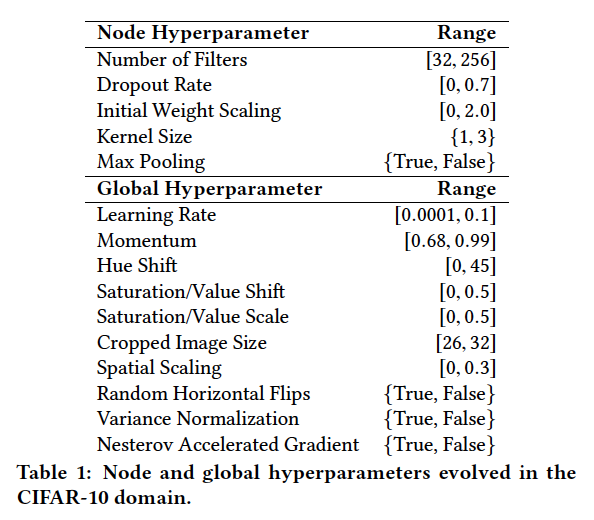

In [ ]:
population = {
    'individual_1':{
        'nodes':{
            'node_1':{
                'type':'input',
                'attributes':None
            },
            'node_2':{
                'type':'output',
                'attributes':None
            },
            'node_3':{
                'type':'convolution',
                'attributes':{
                    'n_filters':32,
                    'dropout':0.7,
                    'kernel_size':3
                }
            },
            'node_4':{
                'type':'pooling',
                'attributes':{
                    'type':'max',
                    'size':2, 
                    'padding':'same'
                }
            },
            'node_5':{
                'type':'convolution',
                'attributes':{
                    'n_filters':8,
                    'dropout':0.2,
                    'kernel_size':1
                }
            },
            'node_6':{
                'type':'dropout',
                'attributes':None
            },
            'node_7':{
                'type':'convolution',
                'attributes':{
                    'n_filters':128,
                    'dropout':0.5,
                    'kernel_size':3
                }
            }
        },
        'connections':{
            'connection_1':{
                'in':'node_1',
                'out':'node_2',
                'enabled':True,
                'innovation':1
            },
            'connection_2':{
                'in':'node_1',
                'out':'node_3',
                'enabled':True,
                'innovation':2
            },
            'connection_3':{
                'in':'node_1',
                'out':'node_2',
                'enabled':True,
                'innovation':3
            },
            'connection_4':{
                'in':'node_1',
                'out':'node_2',
                'enabled':True,
                'innovation':4
            },
            'connection_5':{
                'in':'node_1',
                'out':'node_2',
                'enabled':True,
                'innovation':5
            },
            'connection_6':{
                'in':'node_1',
                'out':'node_2',
                'enabled':True,
                'innovation':7
            },
            'connection_7':{
                'in':'node_1',
                'out':'node_2',
                'enabled':True,
                'innovation':9
            },
            'connection_8':{
                'in':'node_1',
                'out':'node_2',
                'enabled':True,
                'innovation':10
            },
            'connection_9':{
                'in':'node_1',
                'out':'node_2',
                'enabled':True,
                'innovation':11
            },
            'connection_10':{
                'in':'node_1',
                'out':'node_2',
                'enabled':True,
                'innovation':12
            }
        },
        'scores':{
            'fitness':10,
            'diversity_1':None,
            'diversity_2':None
        },
        'meta_data':{
            'n_nodes':7,
            'n_connections':10,
            'n_enabled':10,
            'n_convolution':3,
            'n_pool':1,
            'n_dropout':1
        }
    }
}

In [ ]:
population = {
    'ind_1':{
        'inno_num': 1,
        'from_node':1,
        'to_node':2,
        'type':'convolution',
        'attr':{
            'n_filters':32,
            'dropout':0.7,
            'kernel_size':3
        }
    },
    'ind_2':{
        'inno_num': 1,
        'from_node':1,
        'to_node':2,
        'type':'pool',
        'attr':{
            'type':'max', # average
            'size':2, #[2, 3, 4, 5]
            'padding':'same' # valid
        }
    }
}

Two possible mutations:
* New node
    * Connection is split
    * New innovation number assigned to each new connection formed by adding a new node
* New connection
    * Joins two existing nodes
    * New innovation number assigned for the single connection formed
* In both cases, if the structural mutation is unique then the innovation number is incremented by 1, else, the innovation number is inherited from the connection that exists in other individuals in the population
* In the case where the the nodes are layers of a CNN the innovation might be based on node as well as type.
    * For example: A connection

* A convolutional layer can always be followed by a dropout layer since a dropout layer with a dropout rate of zero is the same as no dropout layer. Pooling layers are likely to always follow convolutional layers (after dropout). Question is, can multiple convolutional layers feed into a pooling layer. In other words can concatenated convolutional layer outputs lead into a single pooling layer?

In [118]:
data.population['individual_1']['connections']

{'connection_1': {'in': 'node_1',
  'out': 'node_3',
  'enabled': True,
  'innovation': 1},
 'connection_2': {'in': 'node_3',
  'out': 'node_2',
  'enabled': True,
  'innovation': 1}}

In [120]:
[data.population['individual_1']['connections'][x]['in'] for x in data.population['individual_1']['connections']]

['node_1', 'node_3']

[x['in'] for x in data.population[individual_id]['connections']]